# GNEE Neural Event Embedding

## Installing our libraries and required scripts

In [1]:
!git clone https://github.com/joaopedromattos/pyGAT
!pip install --quiet spektral

Cloning into 'pyGAT'...
remote: Enumerating objects: 213, done.
remote: Total 213 (delta 0), reused 0 (delta 0), pack-reused 213
Receiving objects: 100% (213/213), 324.96 KiB | 543.00 KiB/s, done.
Resolving deltas: 100% (117/117), done.
     |████████████████████████████████| 122kB 5.8MB/s 


In [2]:
!pip install sentence_transformers

     |████████████████████████████████| 71kB 3.2MB/s 
     |████████████████████████████████| 1.8MB 8.5MB/s 
     |████████████████████████████████| 1.2MB 42.7MB/s 
     |████████████████████████████████| 890kB 43.0MB/s 
     |████████████████████████████████| 3.2MB 44.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.4.1.2-cp36-none-any.whl size=103068 sha256=3a7a42d3494057ae3bb493da61f325a7b9e34b3d33ada2821e61316b3b73b128
  Stored in directory: /root/.cache/pip/wheels/3d/33/d1/5703dd56199c09d4a1b41e0c07fb4e7765a84d787cbdc48ac3
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0ab2afa6f782787c29906510b9d713852b5b613a970b960c5e7f26daf7429134
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [3]:
import os

os.chdir('./pyGAT')

In [4]:
import networkx as nx
from tqdm import tqdm
import pandas as pd
from google.colab import auth
from google.cloud import bigquery
from google.cloud import bigquery_storage
import numpy as np
import logging
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder
from event_graph_utils import mount_graph, regularization, process_event_dataset_from_networkx

# auth.authenticate_user()
# print('Authenticated')

# Graph Example

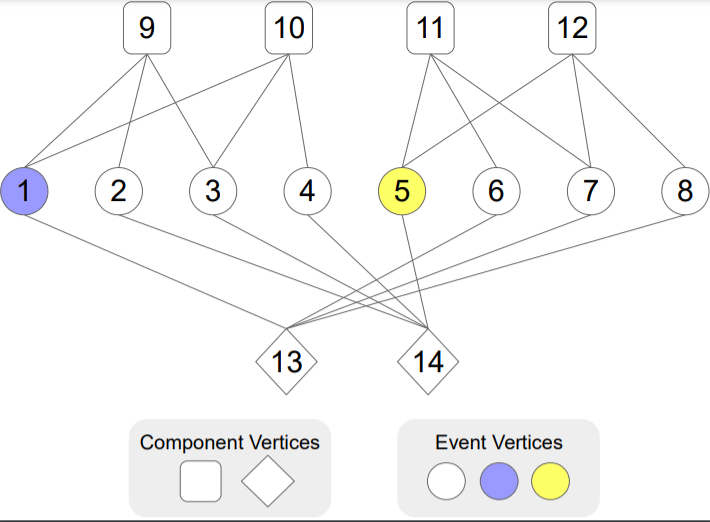


In [5]:
edges = '''1;9
1;13
1;10
2;9
2;14
3;9
3;10
3;14
4;10
4;14
5;11
5;12
5;14
6;11
6;13
7;11
7;12
7;13
8;12
8;13'''.split("\n");
G = nx.Graph()
for e in edges:
  e= e.split(';')
  G.add_edge(e[0],e[1])

In [6]:
G.nodes['1']['label'] = 'a'
G.nodes['1']['train'] = '1'
G.nodes['1']['label'] = 'a'
G.nodes['1']['test'] = '1'

G.nodes['5']['label'] = 'b'
G.nodes['5']['train'] = '1'
G.nodes['5']['label'] = 'b'
G.nodes['5']['test'] = '1'

In [7]:
for e in G.edges():
  print(e)

('1', '9')
('1', '13')
('1', '10')
('9', '2')
('9', '3')
('13', '6')
('13', '7')
('13', '8')
('10', '3')
('10', '4')
('2', '14')
('14', '3')
('14', '4')
('14', '5')
('5', '11')
('5', '12')
('11', '6')
('11', '7')
('12', '7')
('12', '8')


In [8]:
for node in G.nodes():
  G.nodes[node]['id'] = int(node)-1

In [9]:
import numpy as np
from tqdm.notebook import tqdm
import random
import networkx as nx


def features_by_adj(G):

    nodes = []

    for node in G.nodes():
        nodes.append(node)

    adj_matrix = nx.adjacency_matrix(G, nodelist=nodes).todense()

    counter = 0
    for node in nodes:
      G.nodes[node]['f'] = np.array(adj_matrix[counter].tolist()[0])
      counter += 1

    return G

In [10]:
features_by_adj(G)

for n in G.nodes(data=True):
  print(n)

('1', {'label': 'a', 'train': '1', 'test': '1', 'id': 0, 'f': array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])})
('9', {'id': 8, 'f': array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])})
('13', {'id': 12, 'f': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])})
('10', {'id': 9, 'f': array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])})
('2', {'id': 1, 'f': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])})
('14', {'id': 13, 'f': array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0])})
('3', {'id': 2, 'f': array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])})
('4', {'id': 3, 'f': array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])})
('5', {'label': 'b', 'train': '1', 'test': '1', 'id': 4, 'f': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0])})
('11', {'id': 10, 'f': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0])})
('12', {'id': 11, 'f': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1])})
('6', {'id': 5, 'f': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])})
('7', {'id': 6, 'f': array([0, 0,

In [11]:
import numpy as np
import networkx as nx
import random
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import logging
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split


def process_event_dataset_from_networkx(G, features_attr="f"):
    """
    Builds an event graph dataset used in GAT model
    Parameters:
        G -> Graph representation of the event network (Networkx graph)
        df_labels -> user labeled data
        features_att -> Feature attribute of each node (str)
        random_state -> A random seed to train_test_split
    Returns:
        adj -> Sparse and symmetric adjacency matrix of our graph.
        features -> A NumPy matrix with our graph features.
        idx_train -> A NumPy array with the indexes of the training nodes.
        idx_val -> A NumPy array with the indexes of the validation nodes.
        idx_test -> A NumPy array with the indexes of the test nodes.
    """

    num_nodes = len(G.nodes)

    # Organizing our feature matrix...
    L_features = []
    L_train = []
    L_test = []
    L_labels = []
    label_codes = {}
    for node in G.nodes():
      L_features.append( (G.nodes[node]['id'], G.nodes[node]['f']) )
      if 'train' in G.nodes[node]: L_train.append(G.nodes[node]['id'])
      if 'test' in G.nodes[node]: L_test.append(G.nodes[node]['id'])
      if 'label' in G.nodes[node]:
        if G.nodes[node]['label'] not in label_codes: label_codes[G.nodes[node]['label']] = len(label_codes) 
        L_labels.append( [G.nodes[node]['id'],G.nodes[node]['label'],label_codes[G.nodes[node]['label']]] )
    df_features = pd.DataFrame(L_features)
    df_features.columns = ['node_id','embedding']
    features = np.array(df_features.sort_values(by=['node_id'])['embedding'].to_list())

    idx_train = L_train
    idx_test = L_test
    labels = [-1]*num_nodes
    df_labels = pd.DataFrame(L_labels)
    df_labels.columns = ['event_id','label','label_code']
    for index,row in df_labels.iterrows():
      labels[row['event_id']] = row['label_code']

    adj = nx.adjacency_matrix(G)

    return adj, features, labels, idx_train, idx_test, df_labels

# Training

In [12]:
from __future__ import division
from __future__ import print_function

import os
import glob
import time
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import scipy.sparse as sp


from models import GAT, SpGAT


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)

class Namespace(object):
    def __init__(self, adict):
        self.__dict__.update(adict)

class GAT_wrapper():
    def __init__(self, args={"alpha": 0.2, "cuda": True, "dropout": 0.6, "epochs": 10, "fastmode": False, "hidden": 8, "lr": 0.005, "nb_heads": 8, "no_cuda": False, "patience": 100, "seed": 72, "sparse": False, "weight_decay": 0.0005}):

        if (type(args) == dict):
            args = Namespace(args)

        self.args = args

        self.model = None

        self.loss_test = 0.0
        self.acc_test = 0.0

        self.adj = None
        self.features = None
        self.labels = None
        self.idx_train = None
        self.idx_val = None
        self.idx_test = None

    def compute_test(self):
        self.model.eval()
        output = self.model(self.features, self.adj)
        loss_test = F.nll_loss(
            output[self.idx_test], self.labels[self.idx_test])
        acc_test = accuracy(output[self.idx_test], self.labels[self.idx_test])
        print("Test set results:",
              "loss= {:.4f}".format(loss_test.item()),
              "accuracy= {:.4f}".format(acc_test.item()))

        self.loss_test = loss_test
        self.acc_test = acc_test

        return loss_test, acc_test, output[self.idx_test].max(1)[1]

    def train_pipeline(self, adj, features, labels, idx_train, idx_val, idx_test, *args):

        adj = normalize_adj(adj + sp.eye(adj.shape[0]))

        if (sp.issparse(adj)):
            adj = adj.todense()

        if (sp.issparse(features)):
            features = features.todense()

        # With networkx, we no longer need to convert from one-hot encoding...
        #labels = np.where(labels)[1]

        adj = torch.FloatTensor(adj)
        features = torch.FloatTensor(features)
        labels = torch.LongTensor(labels)
        idx_train = torch.LongTensor(idx_train)
        idx_val = torch.LongTensor(idx_val)
        idx_test = torch.LongTensor(idx_test)

        random.seed(self.args.seed)
        np.random.seed(self.args.seed)
        torch.manual_seed(self.args.seed)
        if self.args.cuda:
            torch.cuda.manual_seed(self.args.seed)

        # Load data
        # adj, features, labels, idx_train, idx_val, idx_test = new_load_data(
        #     *args, custom_function=custom_function, function=function)

        # Model and optimizer
        if self.args.sparse:
            model = SpGAT(nfeat=features.shape[1],
                          nhid=self.args.hidden,
                          nclass=int(labels.max()) + 1,
                          dropout=self.args.dropout,
                          nheads=self.args.nb_heads,
                          alpha=self.args.alpha)
        else:
            model = GAT(nfeat=features.shape[1],
                        nhid=self.args.hidden,
                        nclass=int(labels.max()) + 1,
                        dropout=self.args.dropout,
                        nheads=self.args.nb_heads,
                        alpha=self.args.alpha)
        optimizer = optim.Adam(model.parameters(),
                               lr=self.args.lr,
                               weight_decay=self.args.weight_decay)

        if self.args.cuda:
            model.cuda()
            features = features.cuda()
            adj = adj.cuda()
            labels = labels.cuda()
            idx_train = idx_train.cuda()
            idx_val = idx_val.cuda()
            idx_test = idx_test.cuda()

        features, adj, labels = Variable(
            features), Variable(adj), Variable(labels)

        # TODO: Test if these lines could be written below line 41.
        self.adj = adj
        self.features = features
        self.labels = labels
        self.idx_train = idx_train
        self.idx_val = idx_val
        self.idx_test = idx_test

        def train(epoch):
            t = time.time()
            model.train()
            optimizer.zero_grad()
            output = model(features, adj)
            loss_train = F.nll_loss(output[idx_train], labels[idx_train])
            acc_train = accuracy(output[idx_train], labels[idx_train])
            loss_train.backward()
            optimizer.step()

            if not self.args.fastmode:
                # Evaluate validation set performance separately,
                # deactivates dropout during validation run.
                model.eval()
                output = model(features, adj)

            loss_val = F.nll_loss(output[idx_val], labels[idx_val])
            acc_val = accuracy(output[idx_val], labels[idx_val])
            print('Epoch: {:04d}'.format(epoch+1),
                  'loss_train: {:.4f}'.format(loss_train.data.item()),
                  'acc_train: {:.4f}'.format(acc_train.data.item()),
                  'loss_val: {:.4f}'.format(loss_val.data.item()),
                  'acc_val: {:.4f}'.format(acc_val.data.item()),
                  'time: {:.4f}s'.format(time.time() - t))

            return loss_val.data.item()

        # Train model
        t_total = time.time()
        loss_values = []
        bad_counter = 0
        best = self.args.epochs + 1
        best_epoch = 0
        for epoch in range(self.args.epochs):
            loss_values.append(train(epoch))

            torch.save(model.state_dict(), '{}.pkl'.format(epoch))
            if loss_values[-1] < best:
                best = loss_values[-1]
                best_epoch = epoch
                bad_counter = 0
            else:
                bad_counter += 1

            if bad_counter == self.args.patience:
                break

            files = glob.glob('*.pkl')
            for file in files:
                epoch_nb = int(file.split('.')[0])
                if epoch_nb < best_epoch:
                    os.remove(file)

        files = glob.glob('*.pkl')
        for file in files:
            epoch_nb = int(file.split('.')[0])
            if epoch_nb > best_epoch:
                os.remove(file)

        print("Optimization Finished!")
        print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

        # Restore best model
        print('Loading {}th epoch'.format(best_epoch))
        model.load_state_dict(torch.load('{}.pkl'.format(best_epoch)))

        self.model = model

        return model



In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm

adj, features, labels, idx_train, idx_test, df_labels = process_event_dataset_from_networkx(G)
print(adj.shape,features.shape,len(idx_train),len(idx_test))

(14, 14) (14, 14) 2 2


In [14]:
adj

<14x14 sparse matrix of type '<class 'numpy.longlong'>'
	with 40 stored elements in Compressed Sparse Row format>

In [15]:
features

array([[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0]])

In [16]:
labels

[0, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

In [17]:
idx_train

[0, 4]

In [18]:
idx_test

[0, 4]

In [19]:
gat = GAT_wrapper({"alpha": 0.2, "cuda": False, "dropout": 0.0, "epochs": 3, "fastmode": False, "hidden": 2, "lr": 0.05, "nb_heads": 2, "no_cuda": False, "patience": 100, "seed": 72, "sparse": False, "weight_decay": 0.0005})
gat.train_pipeline(adj, features, labels, idx_train, idx_train, idx_test)

att_embedding = gat.model.get_attention_heads_outputs(gat.features,gat.adj).detach().numpy()

Epoch: 0001 loss_train: 0.8153 acc_train: 0.5000 loss_val: 0.5592 acc_val: 1.0000 time: 0.2518s
Epoch: 0002 loss_train: 0.5592 acc_train: 1.0000 loss_val: 0.4619 acc_val: 1.0000 time: 0.0041s
Epoch: 0003 loss_train: 0.4619 acc_train: 1.0000 loss_val: 0.3867 acc_val: 1.0000 time: 0.0038s
Optimization Finished!
Total time elapsed: 0.2653s
Loading 2th epoch


# Event Embeddings from Attention Matrix #1

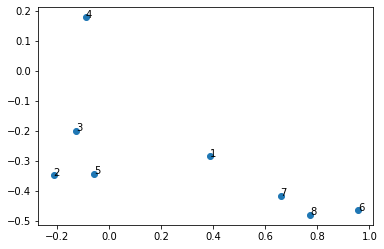

In [20]:
import matplotlib.pyplot as plt

counter = 0
  
for node in G.nodes():
      G.nodes[node]['att_embedding'] = att_embedding[counter]
      counter += 1


y = []
z = []
n = []
for node in G.nodes():
    if int(node) >= 1 and int(node) <= 8:
      
      y.append(G.nodes[node]['att_embedding'][0])
      z.append(G.nodes[node]['att_embedding'][1])
      n.append(node)


fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
      ax.annotate(txt, (z[i], y[i]))

fig.show()

# Event Embeddings from Attention Matrix #2

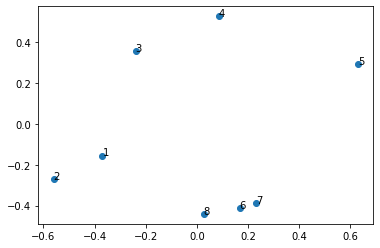

In [21]:
import matplotlib.pyplot as plt

counter = 0
  
for node in G.nodes():
      G.nodes[node]['att_embedding'] = att_embedding[counter]
      counter += 1


y = []
z = []
n = []
for node in G.nodes():
    if int(node) >= 1 and int(node) <= 8:
      
      y.append(G.nodes[node]['att_embedding'][2])
      z.append(G.nodes[node]['att_embedding'][3])
      n.append(node)


fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
      ax.annotate(txt, (z[i], y[i]))

fig.show()